In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy

from scipy.io import loadmat
from scipy.stats import skew, kurtosis

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


### General Functions

In [71]:
def extract_features(data, prefix):
    """
    Extract features for a given time series.

    Parameters:
    - data (list): Time series of interest
    - prefix (str): Prefix used in dictonary for clarity

    Returns:
    - features (dict): Features and their associated values
    """
    
    features = {
        f'{prefix}mean'        : np.mean(data),
        f'{prefix}std'         : np.std(data),
        f'{prefix}pulse'       : np.max(data) - np.mean(data), # np.max(data) / np.mean(data) if np.mean(data) != 0 else 0,
        f'{prefix}peak_to_peak': np.max(data) - np.min(data),
        f'{prefix}kurtosis'    : kurtosis(data),
        f'{prefix}skewness'    : skew(data),
    }
    return features


def process_time_series(data, window_size, overlap, pref, feature_dicts, time_series_dicts):
    """
    Process a time series into overlapping windows and call function to retireve features of these windows

    Parameters:
    - data (list): Time series of interest that will be added to the feature_dicts and time_series_dicts
    - window_size (int): Window size in number of samples
    - overlap (float) : Overlap ratio (0 till 1)
    - pref (str): Prefix used in dataframe for distinction between features from different time series
    - feature_dicts (dict): Current features and their associated labels
    - time_series_dicts (dict): Current time series and their associated labels 
    
    Returns:
    - features (dict): Updated dict containing features and their associated labels;
        added features for data 
    - time_series (dict): Updated dict containing time series and their associated labels 
    """

    step_size = int(window_size * (1 - overlap))
    total_windows = max(0, (len(data) - window_size) // step_size + 1)

    if len(data) < window_size:
        print("Yo man, that window is too big")
        print(f"length of data is {len(data)}, where the length of the window is {window_size}")
    
    for step in range(0, total_windows):
        window = data[step*step_size : step*step_size + window_size]
        features = extract_features(window, prefix=pref)
        feature_dicts[step].update(features)
        ts = {}

        ts[f'{pref}ts'] = window

        time_series_dicts[step].update(ts)

    
    return feature_dicts, time_series_dicts


### PU Functions

In [91]:
def deduce_labels_pu(bearing_id, classification_type):
    """
    Deduce labels for a given bearing_id based on the classification type.
    
    Parameters:
    - bearing_id (str): The ID of the bearing (for example 'KA01', 'KA04').
    - classification_type (str): The type of classification ('binary', 'multiclass')
    
    Returns:
    - int: The label for the given bearing_id.
    """
    # Real damages labels (from Table 5)
    real_damage_labels = {
        "KA04": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "OR", "characteristic": "Single Point"},
        "KA15": {"fault_type": "Plastic Deformation: Indentations", "extent": "Single", "component": "OR", "characteristic": "Single Point"},
        "KA16": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "OR", "characteristic": "Single Point"},
        "KA22": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "OR", "characteristic": "Single Point"},
        "KA30": {"fault_type": "Plastic Deformation: Indentations", "extent": "Distributed", "component": "OR", "characteristic": "Distributed"},
        "KB23": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "OR", "characteristic": "Single Point"}, #+IR
        "KB24": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "OR", "characteristic": "Single Point"}, #+IR
        "KB27": {"fault_type": "Plastic Deformation: Indentations", "extent": "Distributed", "component": "IR", "characteristic": "Distributed"},# OR+
        "KI04": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"},
        "KI14": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"},
        "KI16": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"},
        "KI17": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"},
        "KI18": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"},
        "KI21": {"fault_type": "Fatigue: Pitting", "extent": "Single", "component": "IR", "characteristic": "Single Point"}
    }
    
    # Artificial damages labels (from Table 4)
    artificial_damage_labels = {
        "KA01": {"damage_level": 1, "method": "EDM"},
        "KA03": {"damage_level": 2, "method": "electric engraver"},
        "KA05": {"damage_level": 2, "method": "electric engraver"},
        "KA06": {"damage_level": 2, "method": "drilling"},
        "KA07": {"damage_level": 2, "method": "drilling"},
        "KA08": {"damage_level": 2, "method": "electric engraver"},
        "KA09": {"damage_level": 2, "method": "EDM"},
        "KI01": {"damage_level": 1, "method": "electric engraver"},
        "KI03": {"damage_level": 2, "method": "electric engraver"},
        "KI05": {"damage_level": 2, "method": "electric engraver"},
        "KI07": {"damage_level": 2, "method": "electric engraver"},
        "KI08": {"damage_level": 2, "method": "electric engraver"}
    }

    # Bearing_type is either 'Real Damages', 'Artificially Damaged' or Healthy
    if bearing_id in real_damage_labels:
        bearing_type = 'Real Damages'
    elif bearing_id in artificial_damage_labels:
        bearing_type = 'Artificially Damaged'
    else:
        bearing_type = 'Healthy'

    if ((bearing_id not in real_damage_labels) and (bearing_id not in artificial_damage_labels) and (bearing_type != "Healthy")):
        raise ValueError(f"Bearing ID {bearing_id} not found in real damage labels.")

    # Classification
    ## BINARY
    if classification_type == "binary":
        return 0 if bearing_type == "Healthy" else 1
    
    ## MULTICLASS
    elif classification_type == "multiclass":
        labels = real_damage_labels if bearing_type == "Real Damages" else artificial_damage_labels
        if bearing_type == "Healthy":
            return 0
        else:
            component_map = {"OR": 1, "IR": 2} #  "OR+IR": 3
            return component_map[labels[bearing_id]['component']]
    

def load_pu_dataset(base_dir_list, window_duration, overlap, signal_indices, classification_type="binary"):
    """
    Load the Paderborn University (PU) dataset, process time series into windows (with overlap), 
    and extract features. 

    Parameters:
    - base_dir_list (list): Directories containing bearing folders of interest
    - window_duration (int/float) : Duration of window in seconds
    - overlap (float) : Overlap ratio (0 till 1)
    - signal_indices (list) : Time series which will be used (for example [1,2,6])
        (0) : 'force'           
        (1) : 'phase_current_1'
        (2) : 'phase_current_2'
        (3) : 'speed'
        (4) : 'temp_2_bearing_module'
        (5) : 'torque'
        (6) : 'vibration_1'
    - classification_type (str) : binary/multiclass (see functiondeduce_labels_pu)

    Returns:
    - features (dict): Features and their associated labels
    - time_series (dict): Time series and their associated labels
    """
    features_data = pd.DataFrame()
    time_series_data = pd.DataFrame()
    
    # Traverse directories and process files
    for base_dir in base_dir_list:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith('.mat'):
                    file_path = os.path.join(root, file)
                    mat_data = loadmat(file_path, simplify_cells=True)
                    
                    # Extract label and bearing ID
                    bearing_id = file.split('_')[3]
                    label = deduce_labels_pu(bearing_id, classification_type)
                    
                    # Extract time series
                    file_name = file.split('.')[0]
                    ts_data = mat_data[file_name]['Y'] if 'Y' in mat_data[file_name] else ValueError('There is no Y value')

                    # Initialize feature and time series dictionaries
                    feature_dicts = []
                    time_series_dicts = []

                    for idx, signal in enumerate(ts_data):
                        # Iterate through all signal_indices of interest and update the dictonary in every loop
                        if idx in signal_indices:
                            time_series = signal['Data']
                            sample_rate = extract_sample_rate(signal['Raster'])  # Extract sample rate dynamically

                            window_size = int(window_duration * sample_rate)
                            step_size = int(window_size * (1 - overlap))
                            total_windows = max(0, (len(time_series) - window_size) // step_size + 1) # Total windows needed for the dicts
                            
                            if signal_indices[0] == idx:    # Needs to be done only once
                                feature_dicts.extend([{} for _ in range(total_windows)])
                                time_series_dicts.extend([{} for _ in range(total_windows)])
                            
                            feature_dicts, time_series_dicts = process_time_series(time_series, window_size, overlap, f'{idx}_', feature_dicts, time_series_dicts)

                    # Transform retrieved dictonairies of file to pandas dataframes
                    feature_dicts= pd.DataFrame(feature_dicts)
                    time_series_dicts= pd.DataFrame(time_series_dicts)
                    
                    # Add labels
                    feature_dicts["bearing_id"] = bearing_id
                    feature_dicts["label"] = label
                    time_series_dicts["bearing_id"] = bearing_id
                    time_series_dicts["label"] = label

                    # Concatenate the found dataframes
                    if features_data.empty:               
                        features_data = pd.DataFrame(feature_dicts)
                        time_series_data = pd.DataFrame(time_series_dicts)
                    else:
                        features_data = pd.concat([features_data, feature_dicts], ignore_index=True)
                        time_series_data = pd.concat([time_series_data, time_series_dicts], ignore_index=True)
    return features_data, time_series_data


def extract_sample_rate(raster):
    """
    Extract the sample rate from the 'Raster' field,
    """
    rate_mapping = {
        "Mech_4kHz": 4000,
        "HostService": 63000,
        "Temp_1Hz": 1
    }
    return rate_mapping[raster]

### CRWU Functions

In [3]:
def deduce_labels_crwu(folder_name, recording_id, classification_type="binary"):
    """
    Deduce labels for the CRWU 12k Drive End dataset based on the file name.

    Parameters:
    - folder_name : The name of the folder "normal"
    - bearing_id (str): The name of the .mat file (e.g., 'IR007_0.mat').
    - classification_type (str): The type of classification ('binary', 'multiclass').

    Returns:
    - int: The label for the given file name.
    """
    # Fault mapping for 12k Drive End
    fault_mapping = {
        # Inner Race Faults
        "IR007": {"fault_type": "Inner Race", "fault_diameter": 0.007},
        "IR014": {"fault_type": "Inner Race", "fault_diameter": 0.014},
        "IR021": {"fault_type": "Inner Race", "fault_diameter": 0.021},
        "IR028": {"fault_type": "Inner Race", "fault_diameter": 0.028},

        # Ball Faults
        "B007": {"fault_type": "Ball", "fault_diameter": 0.007},
        "B014": {"fault_type": "Ball", "fault_diameter": 0.014},
        "B021": {"fault_type": "Ball", "fault_diameter": 0.021},
        "B028": {"fault_type": "Ball", "fault_diameter": 0.028},

        # Outer Race Faults (with positions)
        "OR007@6": {"fault_type": "Outer Race", "fault_position": "Centered (6:00)", "fault_diameter": 0.007},
        "OR014@6": {"fault_type": "Outer Race", "fault_position": "Centered (6:00)", "fault_diameter": 0.014},
        "OR021@6": {"fault_type": "Outer Race", "fault_position": "Centered (6:00)", "fault_diameter": 0.021},
        "OR028@6": {"fault_type": "Outer Race", "fault_position": "Centered (6:00)", "fault_diameter": 0.028},

        "OR007@3": {"fault_type": "Outer Race", "fault_position": "Orthogonal (3:00)", "fault_diameter": 0.007},
        "OR021@3": {"fault_type": "Outer Race", "fault_position": "Orthogonal (3:00)", "fault_diameter": 0.021},

        "OR007@12": {"fault_type": "Outer Race", "fault_position": "Opposite (12:00)", "fault_diameter": 0.007},
        "OR021@12": {"fault_type": "Outer Race", "fault_position": "Opposite (12:00)", "fault_diameter": 0.021},
    }


    bearing_id = recording_id.split('_')[0]

    # Determine if it's Normal data
    if "Normal" in folder_name:
        if classification_type == "binary":
            return 0
        elif classification_type == "multiclass":
            return 0

    if bearing_id in fault_mapping:
        if classification_type == "binary":
            return 1  # Faulty
        elif classification_type == "multiclass":
            fault_type = fault_mapping[bearing_id]["fault_type"]
            if fault_type == "Inner Race":
                return 1
            elif fault_type == "Ball":
                return 2
            elif fault_type == "Outer Race":
                return 3

    raise ValueError(f"File name {folder_name} does not match any known labels.")


def load_crwu_dataset(base_dir_list, window_size, overlap, classification_type="binary"):
    """
    Load the Case Western Reserve University (CRWU) dataset, process time series into overlapping windows,
    and extract features.

    Parameters:
    - base_dir (str): The base directory of the CRWU dataset.
    - window_size (int): The length of each window for feature extraction.
    - overlap (float): The overlap between windows (as a fraction of window size).
    - classification_type (str): Type of classification ('binary' or 'multiclass').

    Returns:
    - features_data (pd.DataFrame): Extracted features for each window.
    - time_series_data (pd.DataFrame): Corresponding time series for each window.
    """

    features_data = []
    time_series_data = []
    count = 0
    # Traverse directories and process files
    for base_dir in base_dir_list:
        for root, _, files in os.walk(base_dir):
            for file in files:
                if file.endswith('.mat'):
                    count+=1
                    file_path = os.path.join(root, file)
                    mat_data = loadmat(file_path, simplify_cells=True)
                    # print('file path:', file_path)

                    # Extract label and bearing ID
                    folder_name = os.path.basename(root) # 'Normal' for example
                    recording_id = file.split('.')[0]
                    # print('recording_id:', recording_id)
                    label = deduce_labels_crwu(folder_name, recording_id, classification_type)
                    bearing_id = recording_id#.split('_')[0]
                    # Identify time series fields
                    time_series_keys = [key for key in mat_data.keys() if "DE_time" in key]  # or "FE_time" in key
                    # print(time_series_keys)

                    for key in time_series_keys:
                        time_series = mat_data[key]

                        # Process time series into overlapping windows
                        step_size = int(window_size * (1 - overlap))
                        # total_windows = max(0, (len(time_series) - window_size) // step_size + 1)

                        for start in range(0, len(time_series) - window_size + 1, step_size):
                            window = time_series[start:start + window_size]

                            # Extract features from the window
                            features = extract_features(window, prefix=f"{key.split('_')[-2]}_")
                            features['label'] = label
                            features['bearing_id'] = bearing_id

                            features_data.append(features)

                            # Store time series data
                            time_series_entry = {
                                'time_series': window,
                                'label': label,
                                'bearing_id': bearing_id
                            }
                            time_series_data.append(time_series_entry)

        # Convert lists to DataFrames
        features_df = pd.DataFrame(features_data)
        time_series_df = pd.DataFrame(time_series_data)
    print(count) # How many files
    return features_df, time_series_df


### Model Functions


In [4]:
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import accuracy_score, f1_score, make_scorer


def cl_grid():
    param_grids = {
    'LogisticRegression': {
        'C': [0.1, 1, 10, 50, 100, 150, 200],
        'solver': ['lbfgs'],
        'penalty': ['l1', 'l2', 'none'],
        'multi_class': ['multinomial'],
        'max_iter': [50, 100, 150, 200, 300, 400]
    },
    'SVC': {
        'C': [0.1, 1, 10, 100, 200],
        'max_iter': [500, 1000, 2000], 
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    'RandomForestClassifier': {
        'n_estimators': [10, 50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'class_weight': ['balanced', 'balanced_subsample', None]
    },
    'KNeighborsClassifier': {
        'n_neighbors': [3, 5, 7, 9],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    # 'MLPClassifier': {
    # 'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    # 'activation': ['relu', 'tanh'],
    # 'learning_rate': ['constant', 'adaptive'],
    # 'max_iter': [200, 500]
    # },
    'GaussianNB': {}
    }

    classifiers = {
        'LogisticRegression': LogisticRegression(random_state=42),
        'SVC': SVC(random_state=42),
        'RandomForestClassifier': RandomForestClassifier(random_state=42),
        'KNeighborsClassifier': KNeighborsClassifier(),
        'DecisionTreeClassifier': DecisionTreeClassifier(random_state=42),
        # 'MLPClassifier': MLPClassifier(random_state=42),
        'GaussianNB': GaussianNB(),
    }
    return param_grids, classifiers

def simple_models(data_df, k=3):

    [param_grids, classifiers] = cl_grid()

    # For scoring in gridsearchcv
    f1_macro_scorer = make_scorer(f1_score, average='macro')

    # Initialize KFold
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    unique_bearings = data_df['bearing_id'].unique()

    all_results = []

    for model_name in classifiers.keys():
        grid_search_results = []
        model = classifiers[model_name]
        param_grid = param_grids[model_name]
        print(model_name) # Print for overview

        # Perform K-Fold Cross Validation for this model
        for fold, (train_idx, test_idx) in enumerate(kf.split(unique_bearings), start=1):
            # For fold assign train and test sets
            train_bearings, test_bearings = unique_bearings[train_idx], unique_bearings[test_idx]
            train_df = data_df[data_df['bearing_id'].isin(train_bearings)]
            test_df = data_df[data_df['bearing_id'].isin(test_bearings)]
            X_train = train_df.drop(columns=['label', 'bearing_id']) # Assuming these are the only labels
            y_train = train_df['label']
            X_test = test_df.drop(columns=['label', 'bearing_id'])
            y_test = test_df['label']

            # Scale features
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Grid Search with Cross Validation
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k, scoring='accuracy', verbose=0) # Accuracy/Precision/Recall /f1_macro_scorer
            grid_search.fit(X_train, y_train)

            # Get best model and evaluate on test data
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)


            grid_search_results.append({
                'fold': fold,
                'best_params': grid_search.best_params_,
                'test_accuracy': accuracy_score(y_test, y_pred),
                'f1_score' : f1_score(y_test, y_pred, average='macro')  # Macro F1 for multiclass
            })
        
        model_results_df = pd.DataFrame(grid_search_results)
        model_results_df['model'] = model_name
        all_results.append(model_results_df)

    # Combine all results into a single DataFrame
    final_results = pd.concat(all_results, ignore_index=True)
    return final_results

In [5]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# Encoder model
def build_encoder(input_shape, latent_dim):
    inputs = layers.Input(shape=input_shape)
    
    # Convolutional layers
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(pool_size=2)(x)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', padding='same')(x)
    x = layers.GlobalMaxPooling1D()(x)
    
    # Dense layer to encode into latent space
    latent = layers.Dense(latent_dim, activation='relu', name='latent_space')(x)
    
    model = Model(inputs, latent, name='Encoder')
    return model

# Define input shape and latent dimension
input_shape = (window_size, 1)
latent_dim = 16
encoder = build_encoder(input_shape, latent_dim)
encoder.summary()

NameError: name 'window_size' is not defined

##### Deep

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Define the 1D CNN architecture
class ConvNet1D(nn.Module):
    def __init__(self, input_length, num_classes):
        super(ConvNet1D, self).__init__()
        self.conv1 = nn.Conv1d(1, 32, kernel_size=5, padding=2)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=5, padding=2)
        self.conv3 = nn.Conv1d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        
        # Flatten size after convolutions depends on input_length
        self.flatten_size = input_length // 16 * 256
        self.fc1 = nn.Linear(self.flatten_size, num_classes)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = self.pool(self.relu(self.conv4(x)))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        return x

# CNN training and validation
def train_cnn_model(X_train, y_train, X_test, y_test, input_length, num_classes, epochs=20, batch_size=16, lr=0.001, device="cpu"):
    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)  # Add channel dimension
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.long)

    # Create DataLoader
    train_ds = TensorDataset(X_train_tensor, y_train_tensor)
    test_ds = TensorDataset(X_test_tensor, y_test_tensor)
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, optimizer
    model = ConvNet1D(input_length=input_length, num_classes=num_classes)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Metrics dictionary
    metrics = {'test_loss': [], 'test_accuracy': []}

    # Training loop
    for epoch in range(epochs):
        model.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            output = model(xb)
            loss = criterion(output, yb)
            loss.backward()
            optimizer.step()
        
        # Validation loop
        model.eval()
        total_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for xb, yb in test_dl:
                xb, yb = xb.to(device), yb.to(device)
                output = model(xb)
                loss = criterion(output, yb)
                total_loss += loss.item() * xb.size(0)
                preds = torch.argmax(output, dim=1)
                correct += (preds == yb).sum().item()
                total += xb.size(0)

        avg_loss = total_loss / total
        accuracy = correct / total
        metrics['test_loss'].append(avg_loss)
        metrics['test_accuracy'].append(accuracy)

        if epoch % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

    return metrics

def simple_models_with_cnn(data_df, k=3):
    [param_grids, classifiers] = cl_grid()

    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    unique_bearings = data_df['bearing_id'].unique()

    all_results = []

    # Train traditional classifiers
    for model_name in classifiers.keys():
        grid_search_results = []
        model = classifiers[model_name]
        param_grid = param_grids[model_name]
        print(f"Training {model_name}")  # Print for overview

        for fold, (train_idx, test_idx) in enumerate(kf.split(unique_bearings), start=1):
            # Prepare train and test sets
            train_bearings, test_bearings = unique_bearings[train_idx], unique_bearings[test_idx]
            train_df = data_df[data_df['bearing_id'].isin(train_bearings)]
            test_df = data_df[data_df['bearing_id'].isin(test_bearings)]
            X_train = train_df.drop(columns=['label', 'bearing_id']).values
            y_train = train_df['label'].values
            X_test = test_df.drop(columns=['label', 'bearing_id']).values
            y_test = test_df['label'].values

            # Scale features
            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test)

            # Grid Search with Cross Validation
            grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=k, scoring='accuracy', verbose=0)
            grid_search.fit(X_train, y_train)

            # Evaluate model
            best_model = grid_search.best_estimator_
            y_pred = best_model.predict(X_test)
            grid_search_results.append({
                'fold': fold,
                'model': model_name,
                'best_params': grid_search.best_params_,
                'test_accuracy': accuracy_score(y_test, y_pred),
                'f1_score': f1_score(y_test, y_pred, average='macro')
            })

        model_results_df = pd.DataFrame(grid_search_results)
        all_results.append(model_results_df)

    # Train CNN
    for fold, (train_idx, test_idx) in enumerate(kf.split(unique_bearings), start=1):
        print(f"Training CNN for Fold {fold}")
        # Prepare train and test sets
        train_bearings, test_bearings = unique_bearings[train_idx], unique_bearings[test_idx]
        train_df = data_df[data_df['bearing_id'].isin(train_bearings)]
        test_df = data_df[data_df['bearing_id'].isin(test_bearings)]
        X_train = train_df.drop(columns=['label', 'bearing_id']).values
        y_train = train_df['label'].values
        X_test = test_df.drop(columns=['label', 'bearing_id']).values
        y_test = test_df['label'].values

        # Scale features
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)

        # Train CNN
        input_length = X_train.shape[1]
        num_classes = len(data_df['label'].unique())
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        cnn_metrics = train_cnn_model(X_train, y_train, X_test, y_test, input_length, num_classes, device=device)
        cnn_results = {
            'fold': fold,
            'model': 'CNN',
            'test_accuracy': cnn_metrics['test_accuracy'][-1],  # Last epoch accuracy
            'test_loss': cnn_metrics['test_loss'][-1]           # Last epoch loss
        }
        all_results.append(pd.DataFrame([cnn_results]))

    # Combine all results into a single DataFrame
    final_results = pd.concat(all_results, ignore_index=True)
    return final_results



### PU


#### Data retrieval

In [102]:
window_duration = 2
signal_indices = [1,6]

pu_base_dir_list = ['C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/PU/Healthy',
                    #'C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/PU/Real Damages',]
                    'C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/PU/Real Damages without double']
                    #'C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/PU/Artificially Damaged'

pu_features_df, pu_time_series_df = load_pu_dataset(pu_base_dir_list, 
                                                window_duration=window_duration, 
                                                overlap=0, 
                                                signal_indices=signal_indices, 
                                                classification_type="multiclass")

In [104]:
unique_bearings_pu= pu_features_df['bearing_id'].unique()
print("unique_bearings:",unique_bearings_pu)
unqiue_labels_pu = pu_features_df['label'].unique()
print("unqiue_labels:", unqiue_labels_pu)

pu_features_df

unique_bearings: ['K001' 'K002' 'K003' 'K004' 'K005' 'K006' 'KA04' 'KA15' 'KA16' 'KA22'
 'KA30' 'KI04' 'KI14' 'KI16' 'KI17' 'KI18' 'KI21']
unqiue_labels: [0 1 2]


,1_mean,1_std,1_pulse,1_peak_to_peak,1_kurtosis,1_skewness,6_mean,6_std,6_pulse,6_peak_to_peak,6_kurtosis,6_skewness,bearing_id,label
0,0.019806,1.655916,2.796622,5.585331,-1.493114,0.009493,-0.015760,0.368588,4.214978,9.078979,17.171734,-0.046452,K001,0
1,0.022707,1.657140,2.854335,5.730664,-1.493736,0.007399,-0.015083,0.366189,4.705635,9.533691,17.195674,0.018376,K001,0
2,0.023102,1.704609,2.887690,5.760970,-1.492906,0.008311,-0.016348,0.363422,4.218619,8.184814,15.984370,-0.045906,K001,0
3,0.024717,1.705035,2.901228,5.846379,-1.494448,0.007540,-0.014264,0.362940,4.063947,8.444214,16.040170,0.040517,K001,0
4,0.025464,1.707737,2.872929,5.789899,-1.494797,0.007424,-0.015930,0.362146,4.471497,8.874512,16.452331,0.053062,K001,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2715,-0.069817,1.822545,3.010915,6.004799,-1.495452,0.012489,0.043269,0.287493,1.519231,3.161621,0.373055,-0.008362,KI21,2
2716,-0.070621,1.817662,2.935264,5.966227,-1.502263,0.005667,0.041579,0.283186,1.557542,3.213501,0.395613,0.008975,KI21,2
2717,-0.065654,1.820460,3.037748,6.092963,-1.499975,0.002780,0.040405,0.285493,1.567871,3.109741,0.385467,-0.027352,KI21,2
2718,-0.076793,1.817534,2.983452,5.962784,-1.505291,0.000245,0.042188,0.283300,1.538622,3.250122,0.402077,-0.014273,KI21,2


#### Data visualization

##### Single recordings comparison

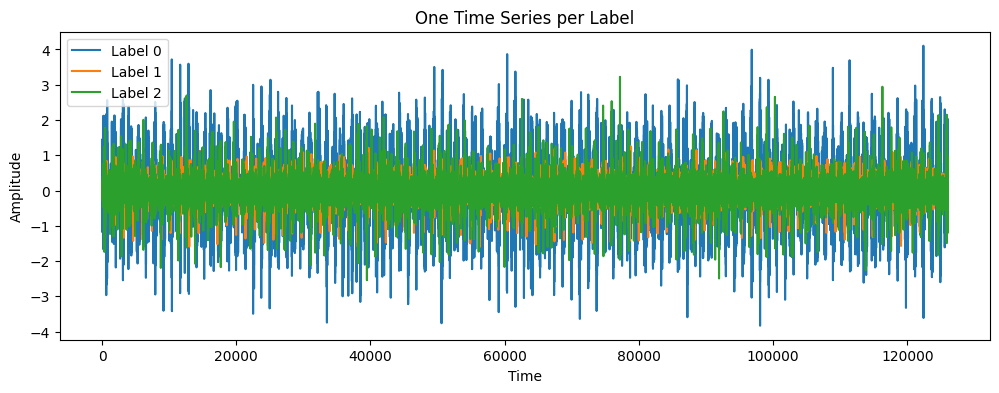

In [109]:
plt.figure(figsize=(12, 4))

for i, label in enumerate(unqiue_labels_pu):
    sample_series = pu_time_series_df[pu_time_series_df['label'] == label].iloc[5]['6_ts']
    plt.plot(sample_series, label=f'Label {label}')

plt.title('One Time Series per Label')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

##### Average recordings comparison

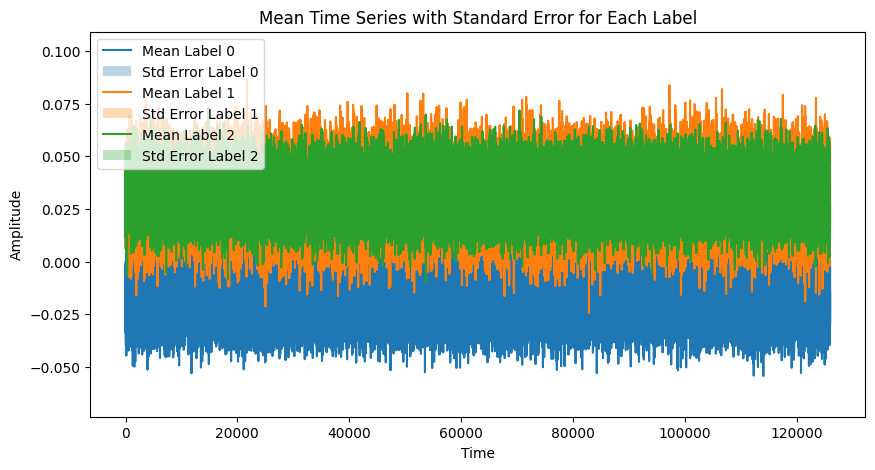

In [118]:
# Function to pad time series to the same length
def pad_time_series(series_list):
    max_length = max(len(s) for s in series_list)   #
    padded_series = np.full((len(series_list), max_length), np.nan)
    for i, s in enumerate(series_list):
        padded_series[i, :len(s)] = s
    return padded_series

# Plotting mean and standard error for each label
unique_labels = pu_time_series_df['label'].unique()

plt.figure(figsize=(10, 5))

for label in unique_labels:
    # Get all time series for the current label
    series_list = pu_time_series_df[pu_time_series_df['label'] == label]['6_ts'].tolist()
    padded_data = pad_time_series(series_list)
    
    # Calculate mean and standard error
    mean_series = np.nanmean(padded_data, axis=0)
    stderr_series = scipy.stats.sem(padded_data, axis=0, nan_policy='omit')
    
    # Plot mean and shaded region for standard error
    plt.plot(mean_series, label=f'Mean Label {label}')
    plt.fill_between(range(len(mean_series)), 
                     mean_series - stderr_series, 
                     mean_series + stderr_series, 
                     alpha=0.3, label=f'Std Error Label {label}')

plt.title('Mean Time Series with Standard Error for Each Label')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

##### Fourier Transform

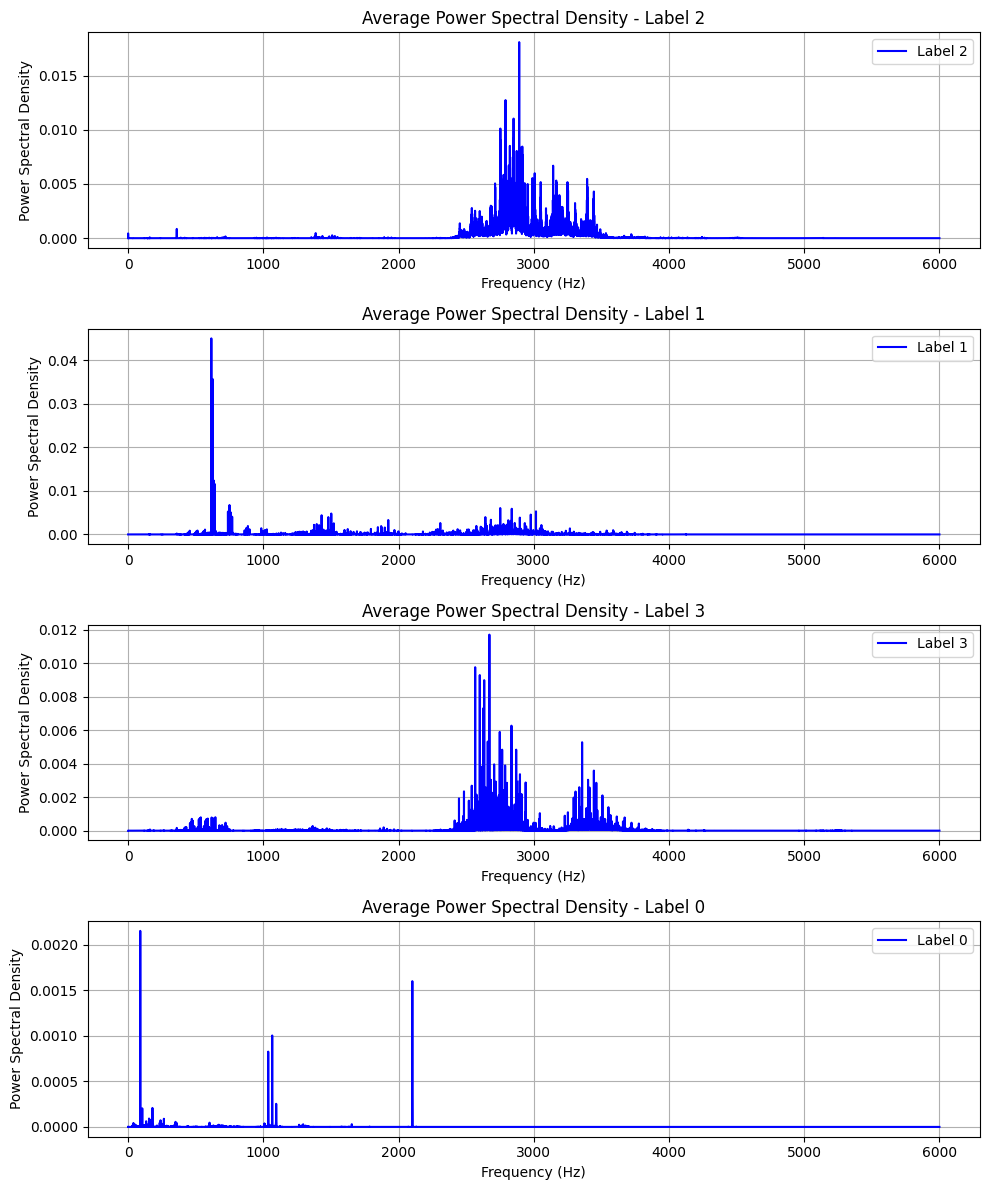

In [117]:
from scipy.signal import periodogram
import numpy as np
import matplotlib.pyplot as plt

# Function to compute average periodogram
def compute_average_periodogram(series_list, sampling_rate=12000):
    freqs = None
    psd_list = []
    
    for series in series_list:
        # Compute the periodogram for each time series
        f, psd = periodogram(series, fs=sampling_rate, scaling='density')
        if freqs is None:
            freqs = f  # Capture frequencies only once
        psd_list.append(psd)
    
    # Average the PSDs across all time series
    mean_psd = np.mean(psd_list, axis=0)
    return freqs, mean_psd

# Plot periodograms for each label
unique_labels = crwu_time_series_df['label'].unique()
num_labels = len(unique_labels)

fig, axes = plt.subplots(num_labels, 1, figsize=(10, 3 * num_labels))
if num_labels == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, label in enumerate(unique_labels):
    # Get all time series for the current label
    series_list = crwu_time_series_df[crwu_time_series_df['label'] == label]['time_series'].tolist()
    
    # Compute average periodogram
    freqs, mean_psd = compute_average_periodogram(series_list)
    
    # Plot the average periodogram
    axes[i].plot(freqs, mean_psd, label=f'Label {label}', color='b')
    axes[i].set_title(f'Average Power Spectral Density - Label {label}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Power Spectral Density')
    axes[i].grid()
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Training


In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

final_results_pu = simple_models(pu_features_df)
# final_results_pu = simple_models_with_cnn(pu_data_df)

LogisticRegression


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

SVC


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297

RandomForestClassifier


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNeighborsClassifier


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


DecisionTreeClassifier
MLPClassifier


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3

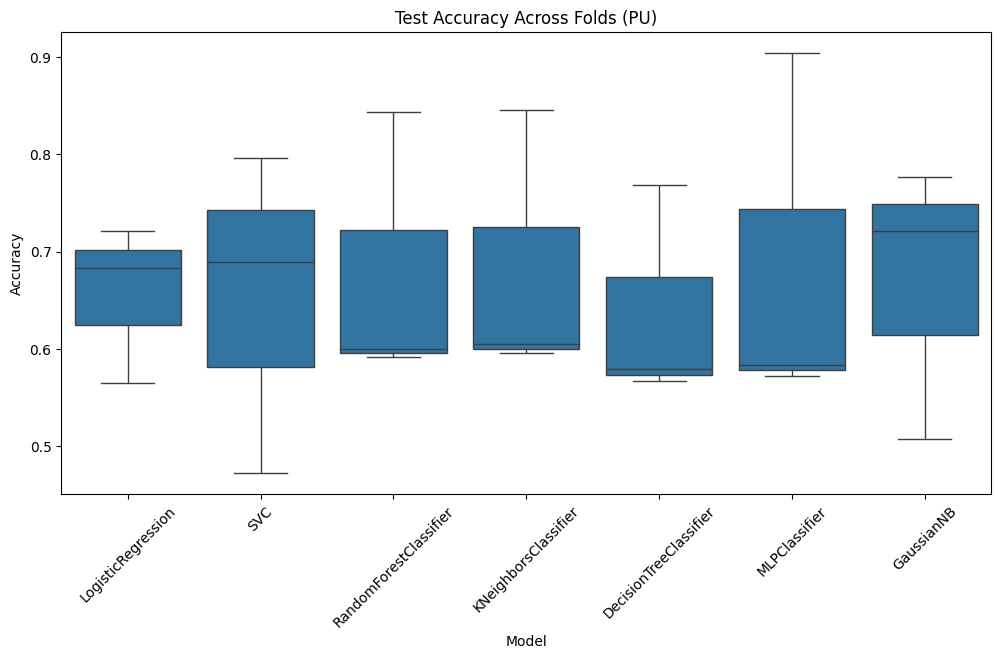

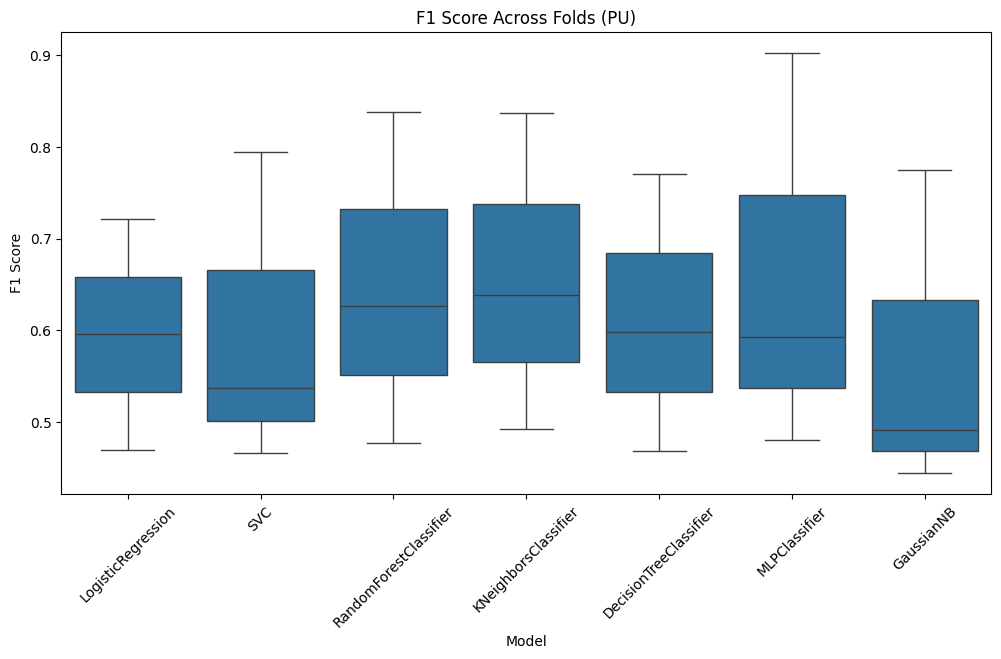

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_results_pu, x='model', y='test_accuracy')
plt.title('Test Accuracy Across Folds (PU)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=final_results_pu, x='model', y='f1_score')
plt.title('F1 Score Across Folds (PU)')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

### CRWU

In [18]:
fs_crwu = 12 * 10**3 # For the 12k case
time_window_crwu = 4 * fs_crwu

crwu_base_dir_list = ['C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/CWRU/Data/12k_DE',
                      'C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/CWRU/Data/Normal']

crwu_data_df, crwu_time_series_df = load_crwu_dataset(crwu_base_dir_list, 
                                                        window_size=time_window_crwu,
                                                        overlap=0,
                                                        classification_type="multiclass")


# print(loadmat('C:/Users/joris/Documents/EE Master/Year 2/Thesis/Dataset/CWRU/Data/12k_DE/B007_3.mat',simplify_cells=True))

64


In [19]:
unique_bearings = crwu_data_df['bearing_id'].unique()
print(unique_bearings)
print(crwu_data_df['label'].unique())
# crwu_time_series_df.head()
crwu_time_series_df

['B007_0' 'B007_1' 'B007_2' 'B007_3' 'B014_0' 'B014_1' 'B014_2' 'B014_3'
 'B021_0' 'B021_1' 'B021_2' 'B021_3' 'B028_0' 'B028_1' 'B028_2' 'B028_3'
 'IR007_0' 'IR007_1' 'IR007_2' 'IR007_3' 'IR014_0' 'IR014_1' 'IR014_2'
 'IR014_3' 'IR021_0' 'IR021_1' 'IR021_2' 'IR021_3' 'IR028_0' 'IR028_1'
 'IR028_2' 'IR028_3' 'OR007@12_0' 'OR007@12_1' 'OR007@12_2' 'OR007@12_3'
 'OR007@3_0' 'OR007@3_1' 'OR007@3_2' 'OR007@3_3' 'OR007@6_0' 'OR007@6_1'
 'OR007@6_2' 'OR007@6_3' 'OR014@6_0' 'OR014@6_1' 'OR014@6_2' 'OR014@6_3'
 'OR021@12_0' 'OR021@12_1' 'OR021@12_2' 'OR021@12_3' 'OR021@3_0'
 'OR021@3_1' 'OR021@3_2' 'OR021@3_3' 'OR021@6_0' 'OR021@6_1' 'OR021@6_2'
 'OR021@6_3' 'Normal_0' 'Normal_1' 'Normal_2' 'Normal_3']
[2 1 3 0]


,time_series,label,bearing_id
0,"[-0.0027613972055888225, -0.09632403193612774,...",2,B007_0
1,"[-0.057177165668662676, 0.06789788423153692, 0...",2,B007_0
2,"[-0.07212119760479042, 0.30310395209580837, 0....",2,B007_1
3,"[0.12734914171656686, 0.05246654690618762, -0....",2,B007_1
4,"[-0.3144744111776447, 0.12198878243512974, 0.3...",2,B007_2
...,...,...,...
160,"[0.09074769230769231, 0.009179076923076922, -0...",0,Normal_3
161,"[0.032544, 0.07593599999999999, 0.108688615384...",0,Normal_3
162,"[0.10222153846153846, 0.05194523076923077, -0....",0,Normal_3
163,"[-0.047772923076923074, -0.002712, 0.034630153...",0,Normal_3


####  Visualization

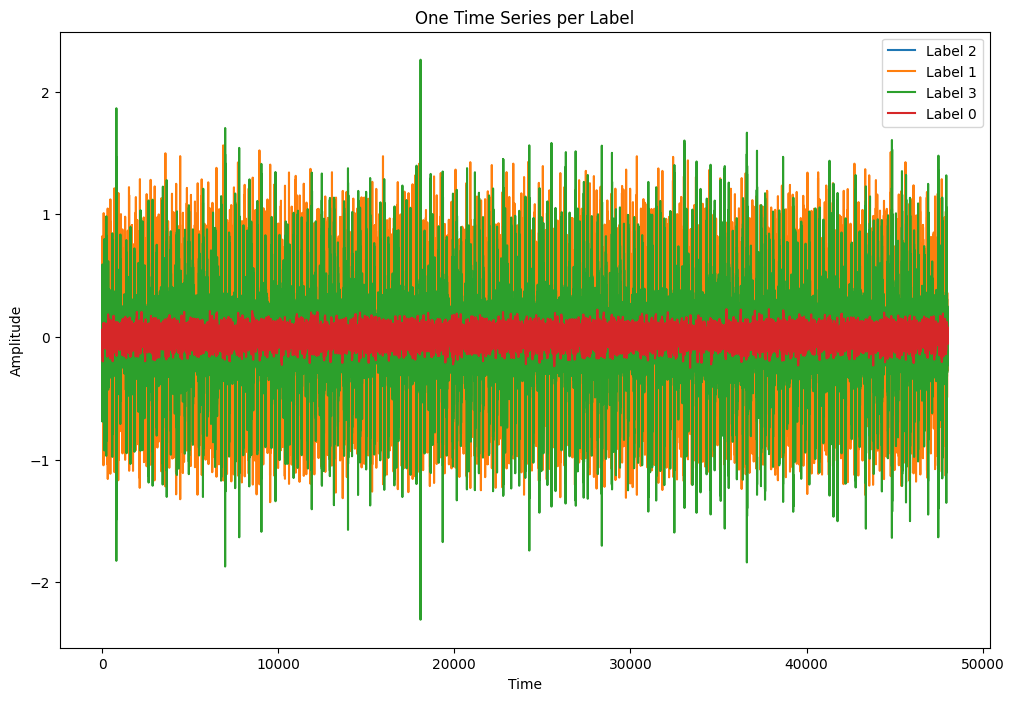

In [31]:
# Ensure the time_series column is a list/array
# crwu_time_series_df['time_series'] = crwu_time_series_df['time_series'].apply(eval) 

# Select one time series per unique label
unique_labels = crwu_time_series_df['label'].unique()

plt.figure(figsize=(12, 8))

for i, label in enumerate(unique_labels):
    sample_series = crwu_time_series_df[crwu_time_series_df['label'] == label].iloc[5]['time_series']
    plt.plot(sample_series, label=f'Label {label}')

plt.title('One Time Series per Label')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

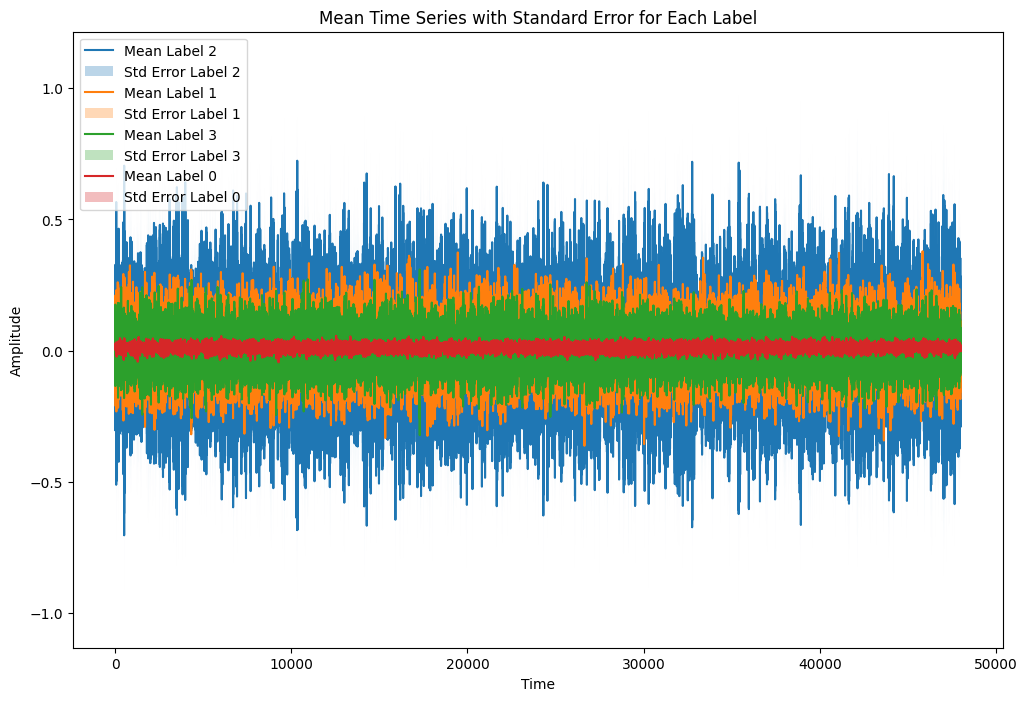

In [22]:
from scipy.stats import sem

# Function to pad time series to the same length
def pad_time_series(series_list):
    max_length = max(len(s) for s in series_list)
    padded_series = np.full((len(series_list), max_length), np.nan)
    for i, s in enumerate(series_list):
        padded_series[i, :len(s)] = s
    return padded_series

# Plotting mean and standard error for each label
unique_labels = crwu_time_series_df['label'].unique()

plt.figure(figsize=(12, 8))

for label in unique_labels:
    # Get all time series for the current label
    series_list = crwu_time_series_df[crwu_time_series_df['label'] == label]['time_series'].tolist()
    padded_data = pad_time_series(series_list)
    
    # Calculate mean and standard error
    mean_series = np.nanmean(padded_data, axis=0)
    stderr_series = sem(padded_data, axis=0, nan_policy='omit')
    
    # Plot mean and shaded region for standard error
    plt.plot(mean_series, label=f'Mean Label {label}')
    plt.fill_between(range(len(mean_series)), 
                     mean_series - stderr_series, 
                     mean_series + stderr_series, 
                     alpha=0.3, label=f'Std Error Label {label}')

plt.title('Mean Time Series with Standard Error for Each Label')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

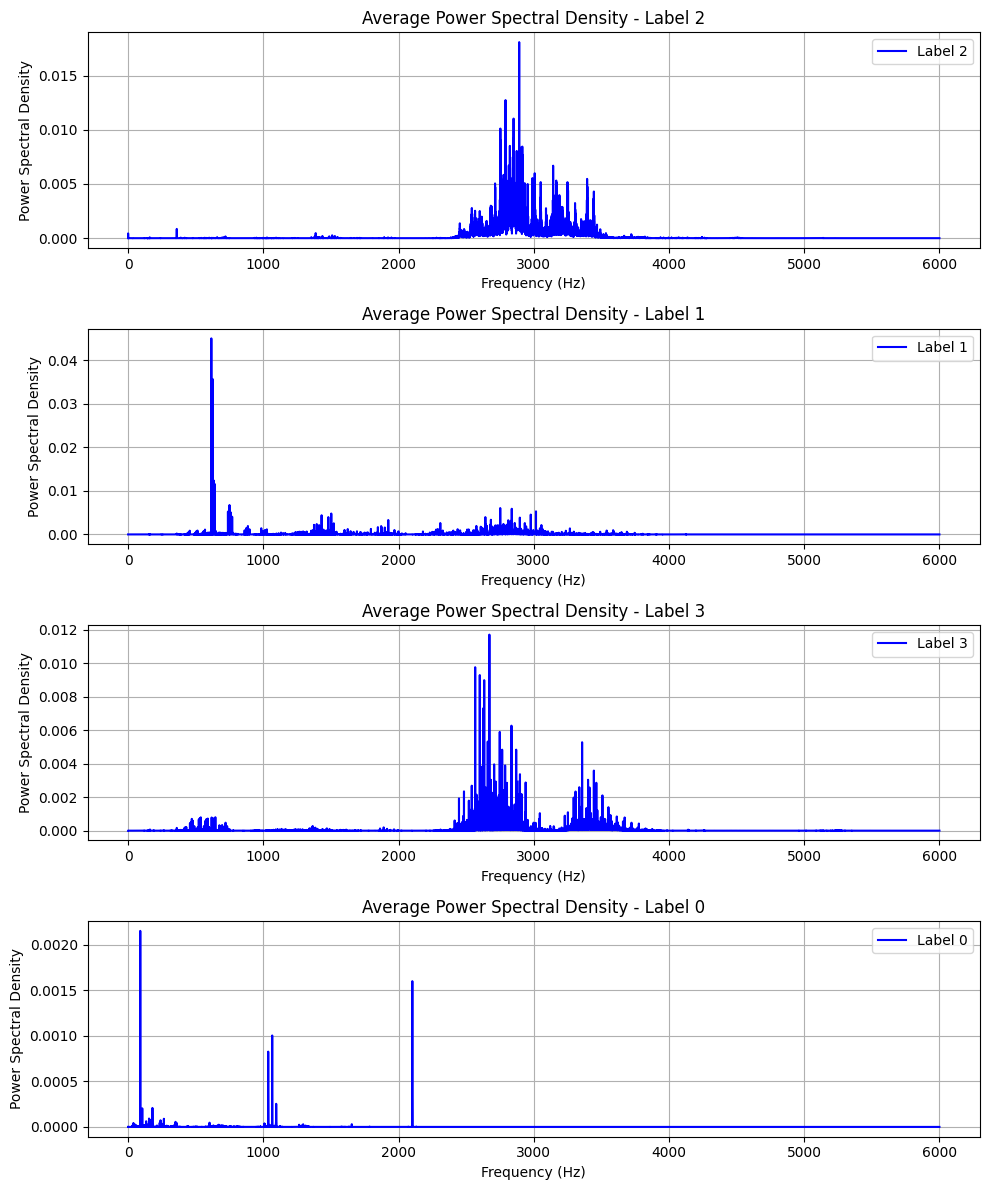

In [34]:
from scipy.signal import periodogram
import numpy as np
import matplotlib.pyplot as plt

# Function to compute average periodogram
def compute_average_periodogram(series_list, sampling_rate=12000):
    freqs = None
    psd_list = []
    
    for series in series_list:
        # Compute the periodogram for each time series
        f, psd = periodogram(series, fs=sampling_rate, scaling='density')
        if freqs is None:
            freqs = f  # Capture frequencies only once
        psd_list.append(psd)
    
    # Average the PSDs across all time series
    mean_psd = np.mean(psd_list, axis=0)
    return freqs, mean_psd

# Plot periodograms for each label
unique_labels = crwu_time_series_df['label'].unique()
num_labels = len(unique_labels)

fig, axes = plt.subplots(num_labels, 1, figsize=(10, 3 * num_labels))
if num_labels == 1:
    axes = [axes]  # Ensure axes is iterable for a single subplot

for i, label in enumerate(unique_labels):
    # Get all time series for the current label
    series_list = crwu_time_series_df[crwu_time_series_df['label'] == label]['time_series'].tolist()
    
    # Compute average periodogram
    freqs, mean_psd = compute_average_periodogram(series_list)
    
    # Plot the average periodogram
    axes[i].plot(freqs, mean_psd, label=f'Label {label}', color='b')
    axes[i].set_title(f'Average Power Spectral Density - Label {label}')
    axes[i].set_xlabel('Frequency (Hz)')
    axes[i].set_ylabel('Power Spectral Density')
    axes[i].grid()
    axes[i].legend()

plt.tight_layout()
plt.show()

#### Training

In [ ]:
final_results_crwu = simple_models(crwu_data_df)

LogisticRegression


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: Futur

SVC


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\svm\_base.py:297:

RandomForestClassifier


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


KNeighborsClassifier
DecisionTreeClassifier
MLPClassifier


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\joris\anaconda3

GaussianNB


c:\Users\joris\anaconda3\envs\thesis\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


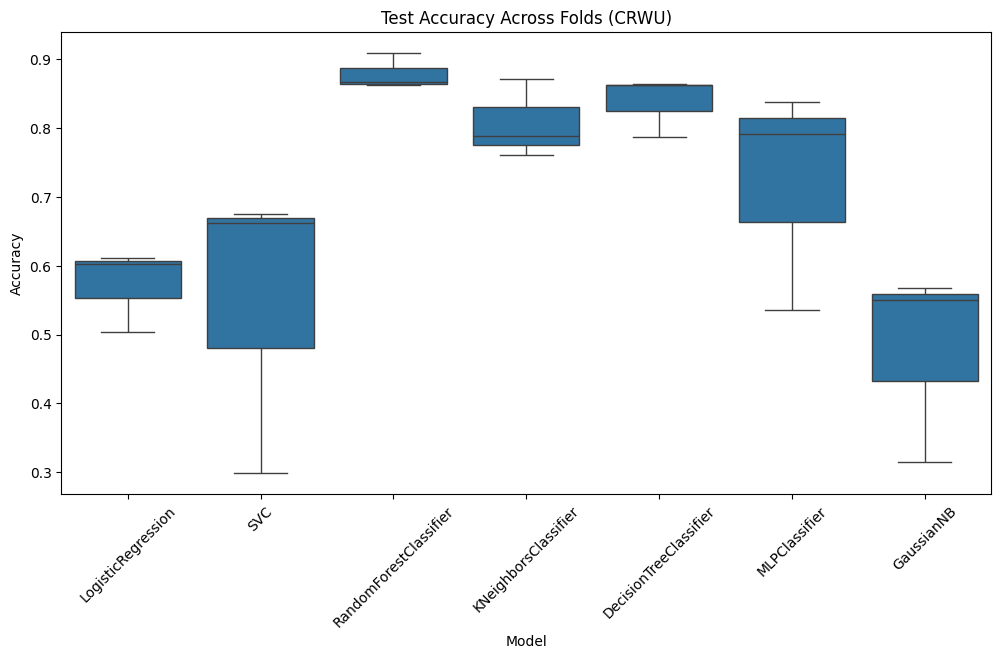

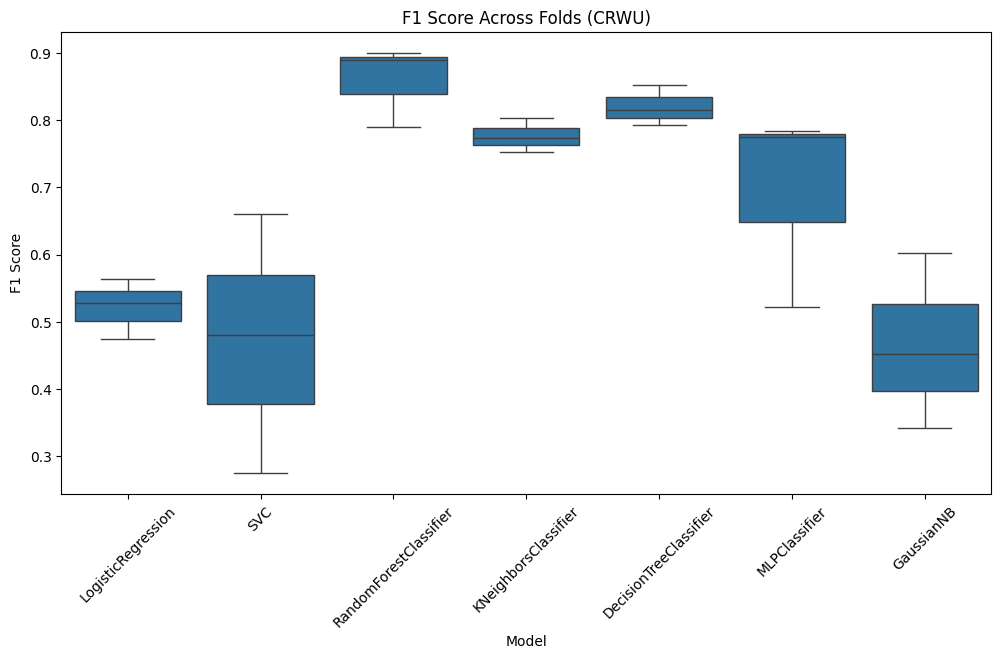

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=final_results_crwu, x='model', y='test_accuracy')
plt.title('Test Accuracy Across Folds (CRWU)')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=final_results_crwu, x='model', y='f1_score')
plt.title('F1 Score Across Folds (CRWU)')
plt.ylabel('F1 Score')
plt.xlabel('Model')
plt.xticks(rotation=45)
plt.show()

## Arduino

In [ ]:
import serial.tools.list_ports
    
ports = serial.tools.list_ports.comports()
print("Available serial ports:")
for port in ports:
    print(f"Port: {port.device} - Description: {port.description}")


Available serial ports:
Port: COM3 - Description: Serieel USB-apparaat (COM3)


In [ ]:
import serial
import time

arduino = serial.Serial(port='COM3', baudrate=9600)

time.sleep(2)


# Send data to the Arduino
data_to_send = "Hello, Arduino!\n"
while True:
    arduino.write(data_to_send.encode())
    print(f"Sent: {data_to_send.strip()}")

    # Wait and read response
    response = arduino.readline().decode().strip()
    print(f"Arduino replied: {response}")

arduino.close()

SerialException: could not open port 'COM3': PermissionError(13, 'Toegang geweigerd.', None, 5)

Error: could not open port 'COM3': PermissionError(13, 'Toegang geweigerd.', None, 5)


In [49]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense

# Example baseline model (very simple)
model = Sequential([
    Dense(8, activation='relu', input_shape=(time_window_crwu,)),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assume X_train, y_train are preloaded

model.fit(X_train, y_train, epochs=5, batch_size=16)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # attempts int8 quantization
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

Epoch 1/5


ValueError: Exception encountered when calling Sequential.call().

[1mInput 0 of layer "dense_30" is incompatible with the layer: expected axis -1 of input shape to have value 8000, but received input with shape (None, 1)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(None, 1), dtype=float32)
  • training=True
  • mask=None

### Majatoch


In [33]:
unique_bearings = crwu_time_series_df['bearing_id'].unique()

train_bearings, test_bearings = train_test_split(unique_bearings, test_size=0.2, random_state=42)

train_df = crwu_time_series_df[crwu_time_series_df['bearing_id'].isin(train_bearings)]
test_df = crwu_time_series_df[crwu_time_series_df['bearing_id'].isin(test_bearings)]

X_train = train_df.drop(columns=['label', 'bearing_id'])
y_train = train_df['label']

X_test = test_df.drop(columns=['label', 'bearing_id'])
y_test = test_df['label']

In [52]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

# Convert Pandas DataFrames to NumPy arrays
X_train = X_train.apply(pd.to_numeric, errors='coerce')  # convert all to numeric
X_train.fillna(0, inplace=True)  # handle NaNs if any appear
X_train_array = X_train.to_numpy(dtype='float32')
y_train_array = y_train.to_numpy() 
y_train_array = to_categorical(y_train_array, num_classes=3)

print(X_train_array.dtype)
print(y_train_array.dtype)
print(X_train_array.shape)
print(y_train_array.shape)

# Example baseline model (very simple)
model = Sequential([
    Dense(8, activation='relu', input_shape=(X_train_array.shape[1],)),
    Dense(1, activation='relu'),
    Dense(4, activation='relu'),
    Dense(1, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train_array, y_train_array, epochs=5, batch_size=16)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # attempts int8 quantization
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

IndexError: index 3 is out of bounds for axis 1 with size 3

In [ ]:
import tensorflow as tf
from keras import Sequential
from keras.layers import Dense

# Example baseline model (very simple)
model = Sequential([
    Dense(8, activation='relu', input_shape=(time_window_crwu,)),
    Dense(4, activation='relu'),
    Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Assume X_train, y_train are preloaded

model.fit(X_train, y_train, epochs=5, batch_size=16)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]  # attempts int8 quantization
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

In [41]:
X_test.iloc[0]

time_series    [-0.0027613972055888225, -0.09632403193612774,...
Name: 0, dtype: object

In [ ]:
import serial
import time

# Adjust to your port and baud rate
ser = serial.Serial('COM3', 115200, timeout=1)
time.sleep(6) # Wait for Arduino reset if needed


# Format data as comma-separated string
data_str = ",".join(map(str, X_test.iloc[0]))
data_str += "\n"  # end with newline so Arduino knows where data ends
ser.write(data_str.encode('utf-8'))

# You may want to wait for a response
response = ser.readline().decode('utf-8').strip()
print("Arduino responded:", response)

ser.close()